# Problem
Train a deep neural network. Your network should work with different architecture parameters (number of layers, number of neurons on each layer, etc.) Try to find the best combination of parameters. Print confusion matrix heatmap as the result.

Dataset: MNIST 

## This implementation features the following:
- variable hidden layers sizes
- variable number of hidden layers 
- different activation functions in the hidden layers (Relu,leakyRelu,Sigmoid)
- softmax layer at the end of the network to recieve probabilities
- log loss function 
- metrics to evaluate the result
- pretrained weights and options to save and load weights

Edit: 
- Sigmoid activation seems not working well. Maybe because of the dataset with a high number of zeros or because of the clip? 
- Trains super fast. Over 90% accuracy in less than 30secs of training


In [385]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [443]:
class NN_MNIST:
        def __init__(self, NNeurons,activation):
            self.av = activation
            self.load_data()
            self.weights,self.bias = self.initialize_NN(NNeurons)
            
        def load_data(self): # Load the MNIST dataset
            self.X, self.y = loadlocal_mnist(
                    images_path='./data/MNIST/train-images.idx3-ubyte',
                    labels_path='./data/MNIST/train-labels.idx1-ubyte')
            self.X = self.X/255  #Normalize the dataset
            self.X, self.y = self.X.T,self.y.T
            self.X_test, self.y_test = loadlocal_mnist(
                    images_path='./data/MNIST/t10k-images.idx3-ubyte',
                    labels_path='./data/MNIST/t10k-labels.idx1-ubyte')
            self.X_test = self.X_test/255  #Normalize the dataset
            self.X_test, self.y_test = self.X_test.T,self.y_test.T
            self.input = self.X.shape[0]
            self.output = 10
            self.sizeX = self.X.shape[1]
            self.sizeY = self.y.shape[0]
            
        def initialize_NN(self,NN):  #initialize all the weights based on parameters
            weights = {}
            bias = {}
            weights[0] = np.random.normal(0,0.1,(NN[0], self.input))
            bias[0] = np.random.normal(0,0.1,(NN[0], 1))
            for x in range(1,len(NN)):
                weights[x] = np.random.normal(0,0.1,(NN[x], NN[x-1]))
                bias[x] = np.random.normal(0,0.1,(NN[x], 1))
            weights[len(NN)] = np.random.normal(0,0.1,(10, NN[len(NN)-1]))
            bias[len(NN)] = np.random.normal(0,0.1,(10, 1))
            return weights,bias
        
        def softmax(self,X):  #Activation functions and derivatives
            X = X-(np.amax(X,axis=0))
            return np.divide(np.exp(X),np.sum( np.exp(X), axis=0,keepdims = True))
        
        def sigmoid(self,Z):
            Z = np.clip(Z, -5, 5)
            return 1 / (1 + np.exp(-Z))
        
        def sigmoid_dev(self,Z):
            Z = np.clip(Z, -5, 5)
            return Z * (1.0 - Z)
        
        def relu(self,Z):
            return np.where(Z<0,0,Z)
        
        def relu_dev(self,Z):
            return np.where(Z<0,0,1)
        
        def leaky_relu(self,Z):
            return np.where(Z<0,0.01*Z,Z)
        
        def leaky_relu_dev(self,Z):
            return np.where(Z<0,0.01,1)
            
        def forward(self,inputs):  #forward step (full data matrics is forwarded at once)
            caches = []
            cache = []
            out = np.dot(self.weights[0],inputs) + self.bias[0]
            cache.append(out)
            if self.av == "sigmoid":
                out = self.sigmoid(out)
                cache.append(out)
                caches.append(cache)
                for x in range (1,len(self.weights)-1):
                    cache = []
                    out = np.dot(self.weights[x],out) + self.bias[x]
                    cache.append(out)
                    out = self.sigmoid(out)
                    cache.append(out)
                    caches.append(cache)
            elif self.av == "relu":
                out = self.relu(out)
                cache.append(out)
                caches.append(cache)
                for x in range (1,len(self.weights)-1):
                    cache = []
                    out = np.dot(self.weights[x],out) + self.bias[x]
                    cache.append(out)
                    out = self.relu(out)
                    cache.append(out)
                    caches.append(cache)
            elif self.av == "leaky_relu":
                out = self.leaky_relu(out)
                cache.append(out)
                caches.append(cache)
                for x in range (1,len(self.weights)-1):
                    cache = []
                    out = np.dot(self.weights[x],out) + self.bias[x]
                    cache.append(out)
                    out = self.leaky_relu(out)
                    cache.append(out)
                    caches.append(cache)
            out = np.dot(self.weights[len(self.weights)-1],out) + self.bias[len(self.weights)-1]
            cache = []
            cache.append(out)
            out = self.softmax(out)
            cache.append(out)
            caches.append(cache)
            return out, np.array(caches)
        
        def backward(self,cache,lr): #backward step based on full dataset (update included)
            dWs = []
            dBs = []
            y = self.oneHotEncoding(self.y)
            dZ = cache[len(cache)-1][1]- y
            dW = np.dot(dZ, cache[len(cache)-2][1].T)/self.sizeX
            dB = np.sum(dZ, axis=1, keepdims=True)/self.sizeX
            dWs.append( lr * dW)
            dBs.append( lr * dB)
            for x in range (len(cache)-1,1,-1): 
                if self.av == "sigmoid":
                    dZ = np.dot(self.weights[x].T,dZ)*self.sigmoid_dev(cache[x-1][0])
                elif self.av == "relu":
                    dZ = np.dot(self.weights[x].T,dZ)*self.relu_dev(cache[x-1][0])
                elif self.av == "leaky_relu":
                    dZ = np.dot(self.weights[x].T,dZ)*self.leaky_relu_dev(cache[x-1][0])
                dW = np.dot(dZ, cache[x-2][1].T)/self.sizeX
                dB = np.sum(dZ, axis=1, keepdims=True)/self.sizeX
                dWs.append( lr * dW)
                dBs.append( lr * dB) 
            if self.av == "sigmoid":
                dZ = np.dot(self.weights[1].T,dZ)*self.sigmoid_dev(cache[0][0])
            elif self.av == "relu":
                dZ = np.dot(self.weights[1].T,dZ)*self.relu_dev(cache[0][0])
            elif self.av == "leaky_relu":
                dZ = np.dot(self.weights[1].T,dZ)*self.leaky_relu_dev(cache[0][0])
            dW = np.dot(dZ, self.X.T)/self.sizeX
            dB = np.sum(dZ, axis=1, keepdims=True)/self.sizeX
            dWs.append( lr * dW)
            dBs.append( lr * dB)
            for y in range(len(dWs)): 
                self.weights[y] = self.weights[y]- dWs[len(dWs)-1-y]
                self.bias[y] = self.bias[y]- dBs[len(dWs)-1-y]
                    
        def oneHotEncoding(self,label): #transform the labels into vectors
            encode = np.zeros((self.output,len(label)))
            for z in range(len(label)):
                encode[self.y[z]][z] = 1
            return encode
        
        def log_loss(self,result): #loss function
            loss = self.oneHotEncoding(self.y)* np.log(result) /self.sizeX
            return -np.sum(loss)
        
        def find_pred(self,probs):   #select the number with the highest probability
            return np.argmax(probs,axis=0)
        
        def confusion_matrix(self,labels,preds): #produce confusion matrix
            confusion = np.zeros((self.output,self.output))
            for x in range(len(preds)):
                confusion[int(labels[x])][int(preds[x])] +=1
            return confusion
        
        def accuracy(self,labels,preds): #accuracy score
            return (np.count_nonzero(np.equal(labels,preds))) / len(labels) *100  
        
        def predict(self,what): #predict either the whole train or test data and display
            if what == "train": # the metrics of the predictions
                prob,cache = self.forward(self.X)
                labels = self.oneHotEncoding(self.y)
            elif what == "test":
                prob,cache = self.forward(self.X_test)
                labels = self.oneHotEncoding(self.y_test)
            predictions = self.find_pred(prob)
            if what == "train":
                CM = self.confusion_matrix(self.y,predictions)
                Accuracy = self.accuracy(self.y,predictions)
            if what == "test":
                CM = self.confusion_matrix(self.y_test,predictions)
                Accuracy = self.accuracy(self.y_test,predictions) 
            print("Accuracy: " + str(Accuracy)+ "%")
            df_cm = pd.DataFrame(CM, index = [i for i in "0123456789"],columns = [i for i in "0123456789"])
            plt.figure(figsize = (10,7))
            ax = plt.axes()
            ax.set_title('True Labels = Rows, Predictions = Columms')
            sn.set(font_scale=1)
            sn.heatmap(df_cm, annot=True,cbar = False)
            
        def train(self,lr,iterations):  #Loop over forward and backward as long as you want
            for x in range(iterations):
                result,cache = self.forward(self.X)
                if x%10 == 0:
                    print(self.log_loss(result))
                self.backward(cache,lr)
                
        def save_weights(self):  #save your weights or load preloaded weights
            for x in range(len(weights)):
                np.savetxt("pretrain/weights" + str(x),self.weights[x])
                np.savetxt("pretrain/bias" + str(x),self.bias[x])
        
        def load_weights(self,layerN):
            self.weights,self.bias = [],[]
            for x in range(layerN):
                self.bias.append(np.expand_dims(np.loadtxt("pretrain/bias" + str(x)),axis=1))
                self.weights.append(np.loadtxt("pretrain/weights" + str(x)))        

In [453]:
NN = NN_MNIST([100,50],"relu")

In [454]:
NN.train(0.3,100)

2.369945113232106
1.5548627425066328
0.822291744771978
0.62810694881855
0.636840842125815
0.5010317846716209
0.4308776753808687
0.41877644256149743
0.38722808261534325
0.37038333989502314


Accuracy: 90.22%


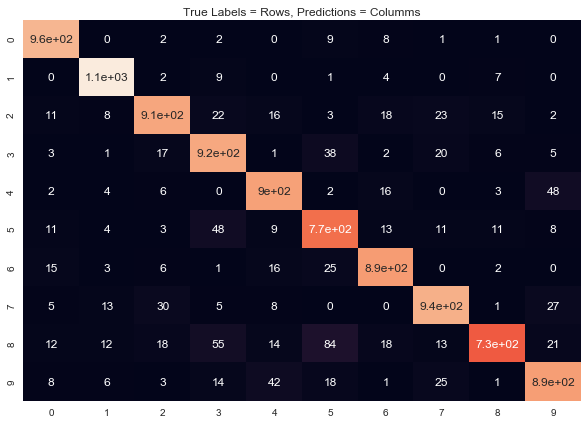

In [455]:
NN.predict("test")

In [451]:
NN.load_weights(2)